In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [251]:
data = pd.read_csv('../../data/panel_data.csv')
data['year'] = [element.split('-')[0] for element in data['time']]
data['month'] = [element.split('-')[1] for element in data['time']]
data['t2m_squared'] = data['t2m'] ** 3
data['tp_squared'] = data['tp'] ** 3
# data['cases'] = np.log(data['cases'] + 1)
data['t2m_tp'] = data['t2m'] * data['tp']
data['time'] = pd.to_datetime(data['time'])
dummies  = pd.get_dummies(data['month'], drop_first=True)
dummies = dummies.astype(int)
dummies = dummies.rename(columns={col: f'month_{col}' for col in dummies.columns})
data = pd.concat([data, dummies], axis=1)
data.head()

,time,state,t2m,tp,lai_hv,lai_lv,cases,deaths,year,month,...,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,2020-01-01,TIBESTI,13.226863,0.006183,0.010336,0.264653,15.0,0.0,2020,01,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-01,BORKOU,17.938311,0.001743,0.013868,0.356516,80.0,0.0,2020,01,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-01,ENNEDI OUEST,14.834963,0.001229,0.053228,0.344716,58.0,0.0,2020,01,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-01,WADI FIRA,18.471732,0.001052,0.268617,0.859191,600.0,0.0,2020,01,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-01,SALAMAT,25.261679,0.001052,0.567471,1.311763,621.0,3.0,2020,01,...,0,0,0,0,0,0,0,0,0,0


In [252]:
data.set_index(['state', 'time'], inplace=True)
for column in data.columns:
    data[column] = pd.to_numeric(data[column])
print(data.dtypes)

t2m            float64
tp             float64
lai_hv         float64
lai_lv         float64
cases          float64
deaths         float64
year             int64
month            int64
t2m_squared    float64
tp_squared     float64
t2m_tp         float64
month_02         int64
month_03         int64
month_04         int64
month_05         int64
month_06         int64
month_07         int64
month_08         int64
month_09         int64
month_10         int64
month_11         int64
month_12         int64
dtype: object


In [253]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    return result[0], result[1]  # Test statistic, p-value

def test_unit_roots(data):
    results = {}
    for feature in ['t2m', 'tp', 't2m_squared', 'tp_squared', 't2m_tp']:
        print(f"===================> Serie: {feature} <===================")
        print('{:<20}   {:<15}    {:<10}'.format('State', 'ADF-statistic', 'p-value'))
        results[feature] = data[feature].groupby(level=0).apply(adf_test)
        results_df = pd.DataFrame(results[feature]).T
        for index in results[feature].index:
            print('{:<20}   {:<15.2f}    {:<10.4f}'.format(index, results[feature][index][0], results[feature][index][1]))
    return results

results_unit_root = test_unit_roots(data)

===================> Serie: t2m <===================
State                  ADF-statistic      p-value   
BAHR EL GAZEL          -7.46              0.0000    
BATHA                  -7.30              0.0000    
BORKOU                 -4.95              0.0000    
CHARI BAGUIRMI         -6.68              0.0000    
ENNEDI EST             -4.87              0.0000    
ENNEDI OUEST           -4.91              0.0000    
GUERA                  -6.21              0.0000    
HADJER LAMIS           -7.19              0.0000    
KANEM                  -9.48              0.0000    
LAC                    -6.73              0.0000    
LOGONE OCCIDENTAL      -1.44              0.5621    
LOGONE ORIENTAL        -1.38              0.5896    
MANDOUL                -1.27              0.6407    
MAYO KEBBI EST         -1.48              0.5424    
MAYO KEBBI OUEST       -1.19              0.6761    
MOYEN CHARI            -1.11              0.7106    
NDJAMENA               -7.38              0.00

In [254]:
data = data.groupby(level=0).diff()
data.dropna(inplace=True)

for col in data.columns:
    if col.startswith('month_'):
        data[col] = data[col].abs()
        
data

,,t2m,tp,lai_hv,lai_lv,cases,deaths,year,month,t2m_squared,tp_squared,...,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
state,time,,,,,,,,,,,,,,,,,,,,,
TIBESTI,2020-02-01,2.269755,-0.004649,0.000000,0.000014,13.0,0.0,0.0,1.0,1407.399747,-2.327110e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BORKOU,2020-02-01,2.384141,-0.000542,0.000000,0.000014,31.0,0.0,0.0,1.0,2620.971473,-3.560704e-09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENNEDI OUEST,2020-02-01,2.591813,0.000270,0.000000,0.000143,-2.0,0.0,0.0,1.0,2027.560899,1.514663e-09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WADI FIRA,2020-02-01,2.557345,-0.000076,-0.000099,0.007416,-138.0,0.0,0.0,1.0,2996.876403,-2.361195e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SALAMAT,2020-02-01,3.278872,-0.000077,0.000623,-0.009311,-54.0,1.0,0.0,1.0,7127.276881,-2.374289e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAYO KEBBI OUEST,2023-12-01,-2.242579,-0.118798,-0.206052,-0.143464,-2015.0,0.0,0.0,1.0,-5259.392407,-1.695094e-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
MOYEN CHARI,2023-12-01,-1.106541,-0.247411,-0.082196,-0.313329,-1306.0,0.0,0.0,1.0,-2671.754368,-1.525859e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
TANDJILE,2023-12-01,-2.096528,-0.158921,-0.038455,-0.311047,-3224.0,0.0,0.0,1.0,-4844.892899,-4.046714e-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [255]:
results_unit_root = test_unit_roots(data)

===================> Serie: t2m <===================
State                  ADF-statistic      p-value   
BAHR EL GAZEL          -5.12              0.0000    
BATHA                  -5.05              0.0000    
BORKOU                 -5.16              0.0000    
CHARI BAGUIRMI         -5.62              0.0000    
ENNEDI EST             -5.54              0.0000    
ENNEDI OUEST           -5.30              0.0000    
GUERA                  -6.41              0.0000    
HADJER LAMIS           -5.42              0.0000    
KANEM                  -5.04              0.0000    
LAC                    -5.46              0.0000    
LOGONE OCCIDENTAL      -6.17              0.0000    
LOGONE ORIENTAL        -6.28              0.0000    
MANDOUL                -6.19              0.0000    
MAYO KEBBI EST         -6.22              0.0000    
MAYO KEBBI OUEST       -5.64              0.0000    
MOYEN CHARI            -5.43              0.0000    
NDJAMENA               -5.15              0.00

In [262]:
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

y = data['cases']
# X = data[['t2m', 'tp']]
# X = data[['t2m', 'tp', 't2m_squared', 'tp_squared', 't2m_tp']]
X = data[['t2m', 'tp', 't2m_tp'] + [col for col in data.columns if col.startswith('month_')] ]
# X = data[['t2m', 'tp', 't2m_squared', 'tp_squared', 't2m_tp'] + [col for col in data.columns if col.startswith('month_')] ]
# X = data[['t2m', 'tp'] + [col for col in data.columns if col.startswith('month_')] ]
X_constant = sm.add_constant(X)  # Adding a constant

# 1. OLS model

In [263]:
fe_model = PanelOLS(y, X, entity_effects=True)
fe_results = fe_model.fit()
print(fe_results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  cases   R-squared:                        0.3483
Estimator:                   PanelOLS   R-squared (Between):              0.0142
No. Observations:                1081   R-squared (Within):               0.3483
Date:                Mon, Nov 25 2024   R-squared (Overall):              0.3481
Time:                        17:02:40   Log-likelihood                   -9727.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      42.968
Entities:                          23   P-value                           0.0000
Avg Obs:                       47.000   Distribution:                 F(13,1045)
Min Obs:                       47.000                                           
Max Obs:                       47.000   F-statistic (robust):             37.917
                            

Handling Heteroscedasticity

To deal with heteroscedasticity, you can use robust standard errors. The linearmodels package allows you to specify robust standard errors directly:

In [258]:
# Fit the model with robust standard errors
fe_results_robust = fe_model.fit(cov_type='kernel', kernel='bartlett')

# Print the results with robust standard errors
print(fe_results_robust)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  cases   R-squared:                        0.3562
Estimator:                   PanelOLS   R-squared (Between):              0.0391
No. Observations:                1081   R-squared (Within):               0.3562
Date:                Mon, Nov 25 2024   R-squared (Overall):              0.3560
Time:                        17:01:58   Log-likelihood                   -9720.6
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      38.467
Entities:                          23   P-value                           0.0000
Avg Obs:                       47.000   Distribution:                 F(15,1043)
Min Obs:                       47.000                                           
Max Obs:                       47.000   F-statistic (robust):             61.273
                            

# 2. Random effects model

In [267]:
from linearmodels.panel import RandomEffects

# Fit the random effects model
re_model = RandomEffects(y, X)
re_results = re_model.fit()

# Print the random effects results
print(re_results)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  cases   R-squared:                        0.3481
Estimator:              RandomEffects   R-squared (Between):              0.0142
No. Observations:                1081   R-squared (Within):               0.3483
Date:                Mon, Nov 25 2024   R-squared (Overall):              0.3481
Time:                        17:03:23   Log-likelihood                   -9727.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      43.833
Entities:                          23   P-value                           0.0000
Avg Obs:                       47.000   Distribution:                 F(13,1067)
Min Obs:                       47.000                                           
Max Obs:                       47.000   F-statistic (robust):             38.681
                            

# 3. Hausman test

In [268]:
from linearmodels.panel import compare

model_results = {
    'Fixed Effects': fe_results,
    'Random Effects': re_results
}

# Perform the Hausman test
hausman_test = compare(model_results, precision="pvalues", stars=True)

# Display the results
print(hausman_test)

                     Model Comparison                    
                          Fixed Effects    Random Effects
---------------------------------------------------------
Dep. Variable                     cases             cases
Estimator                      PanelOLS     RandomEffects
No. Observations                   1081              1081
Cov. Est.                    Unadjusted        Unadjusted
R-squared                        0.3483            0.3481
R-Squared (Within)               0.3483            0.3483
R-Squared (Between)              0.0142            0.0142
R-Squared (Overall)              0.3481            0.3481
F-statistic                      42.968            43.833
P-value (F-stat)                 0.0000            0.0000
=====================     =============   ===============
t2m                          -104.43***        -104.53***
                               (0.0084)          (0.0077)
tp                            3964.2***         3964.7***
              

In [270]:
from scipy import stats
b_fixed = fe_results.params
b_random = re_results.params
cov_fixed = fe_results.cov
cov_random = re_results.cov

# Calculate the difference in coefficients
diff = b_fixed - b_random

# Calculate the Hausman statistic
hausman_stat = diff.T @ (cov_fixed - cov_random).dot(diff)
df = len(b_fixed)  # Degrees of freedom

# Calculate the p-value
p_value = 1 - stats.chi2.cdf(hausman_stat, df)

# Print the Hausman Test results (H0: Random Effects is consistent and efficient)
print(f"Hausman Test Statistic: {hausman_stat}")
print(f"P-value: {p_value}")

Hausman Test Statistic: 2688.8030379150755
P-value: 0.0


# 4. Robusness checks for the best model (Random Effects)

In [273]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan

re_model_constant = RandomEffects(y, X_constant, check_rank=False)
re_results_constant = re_model_constant.fit(cov_type='kernel', kernel='bartlett')

residuals_constant = re_results_constant.resids

# Run an auxiliary regression of squared residuals on the independent variables
aux_model = sm.OLS(residuals_constant**2, X_constant).fit()

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(aux_model.resid, aux_model.model.exog)

# Collect and print the results
bp_test_results = dict(zip(['LM Statistic', 'p-value', 'f-value', 'f p-value'], bp_test))
print("Breusch-Pagan Test Results (H0: Homoscedasticity):")
for key, value in bp_test_results.items():
    print("{:<3} : {:<3}".format(key, value))

Breusch-Pagan Test Results (H0: Homoscedasticity):
LM Statistic : 28.604071013740437
p-value : 0.011816677108281251
f-value : 2.2308468434908497
f p-value : 0.007076583445464966


In [215]:
from statsmodels.stats.stattools import durbin_watson

# re_results = re_model.fit(cov_type='kernel', kernel='bartlett')
residuals = re_results.resids
# Wooldridge test for autocorrelation
dw_statistic = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_statistic}')

Durbin-Watson statistic: 1.7037716906056657


Model Specification Tests

You can use the Ramsey RESET test to check for model specification issues.

In [216]:
from statsmodels.stats.outliers_influence import reset_ramsey

ols_model = sm.OLS(y, X).fit()
reset_test = reset_ramsey(ols_model)
print(f'F-statistic: {reset_test.statistic}')
print(f'Ramsey RESET test p-value: {reset_test.pvalue}')
print(f'df_denom: {reset_test.df_denom}')
print(f'df_num: {reset_test.df_num}')

F-statistic: 3.057311162569439
Ramsey RESET test p-value: 0.016124565348232863
df_denom: 1064.0
df_num: 4.0


# 5. Extract effects

In [274]:
effects = re_model_constant.estimated_effects
state_effects = effects.groupby(level='state')['estimated_effects'].mean()
state_effects

AttributeError: 'RandomEffects' object has no attribute 'estimated_effects'

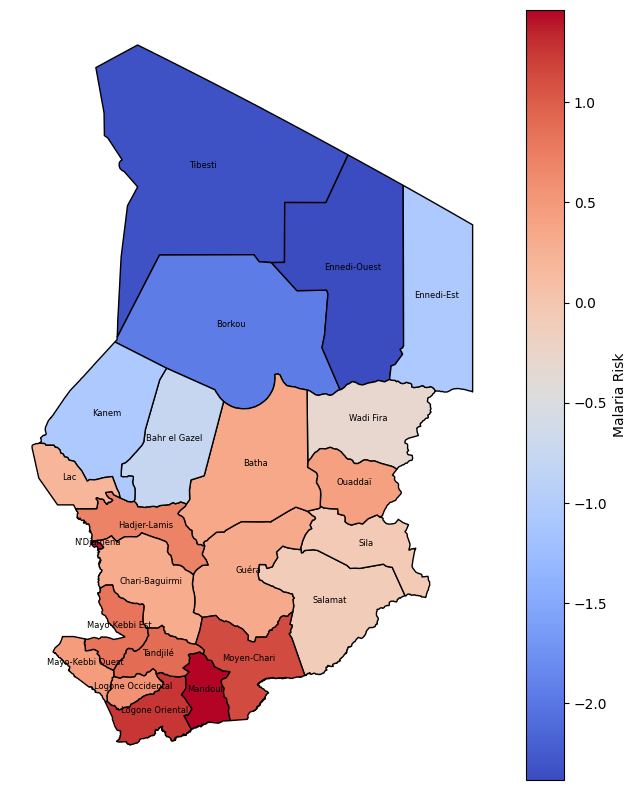

In [392]:
import geopandas as gpd

map_data = gpd.read_file('../../data/chadgeodata/geoBoundaries-TCD-ADM1-all/geoBoundaries-TCD-ADM1.geojson')
map_data.loc[21, 'shapeName'] = "N'Djamena"
shape_names = map_data['shapeName'].tolist()
shape_names.sort()
map_data['risk'] = [None]*23
for element in shape_names:
    map_data.loc[map_data['shapeName']==element, 'risk'] = state_effects.iloc[shape_names.index(element)]
map_data['risk'] = pd.to_numeric(map_data['risk'], errors='coerce')

map_data = map_data.to_crs(epsg=3857) 

fig, ax = plt.subplots(1, 1, figsize=(8, 10))

# ax = plt.axes(projection=ccrs.PlateCarree())
map_data.plot(edgecolor='black', column='risk', cmap='coolwarm', ax=ax, legend=True,
              legend_kwds={'label': "Malaria Risk", 'orientation': "vertical"})
for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data['shapeName']):
    ax.annotate(label, xy=(x, y), fontsize=6, ha='center')
plt.axis('off')

plt.show()

In [394]:
effects_reset = effects.reset_index()
effects_reset['month'] = [time.month for time in effects_reset['time']]
month_effects = effects_reset.groupby('month')['estimated_effects'].mean().reset_index()
month_effects

,month,estimated_effects
0,1,0.014317
1,2,0.014317
2,3,0.014317
3,4,0.014317
4,5,0.014317
5,6,0.014317
6,7,0.014317
7,8,0.014317
8,9,0.014317
9,10,0.014317


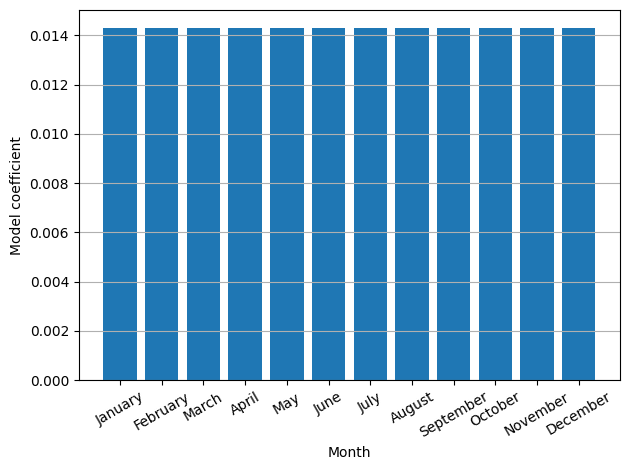

In [403]:
import matplotlib.pyplot as plt

# Corrected months list
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plotting the mean of 'beta_month' across the samples
plt.bar(months, month_effects['estimated_effects'])

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Model coefficient')
# plt.title('Mean beta_month Coefficients by Month')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=30)
plt.tight_layout()
plt.grid(axis='y')

# 6. Performance metrics

In [432]:
rmse = np.sqrt(((np.exp(re_results.fitted_values['fitted_values']) - np.exp(y))**2).mean())
mae = np.abs(np.exp(re_results.fitted_values['fitted_values']) - np.exp(y)).mean()

print('RMSE:', rmse)
print('MAE:', mae)
print(f'Bayesian R-squared: {re_results.rsquared}')

RMSE: 5872.954920560728
MAE: 3523.723773202064
Bayesian R-squared: 0.7837303668788614


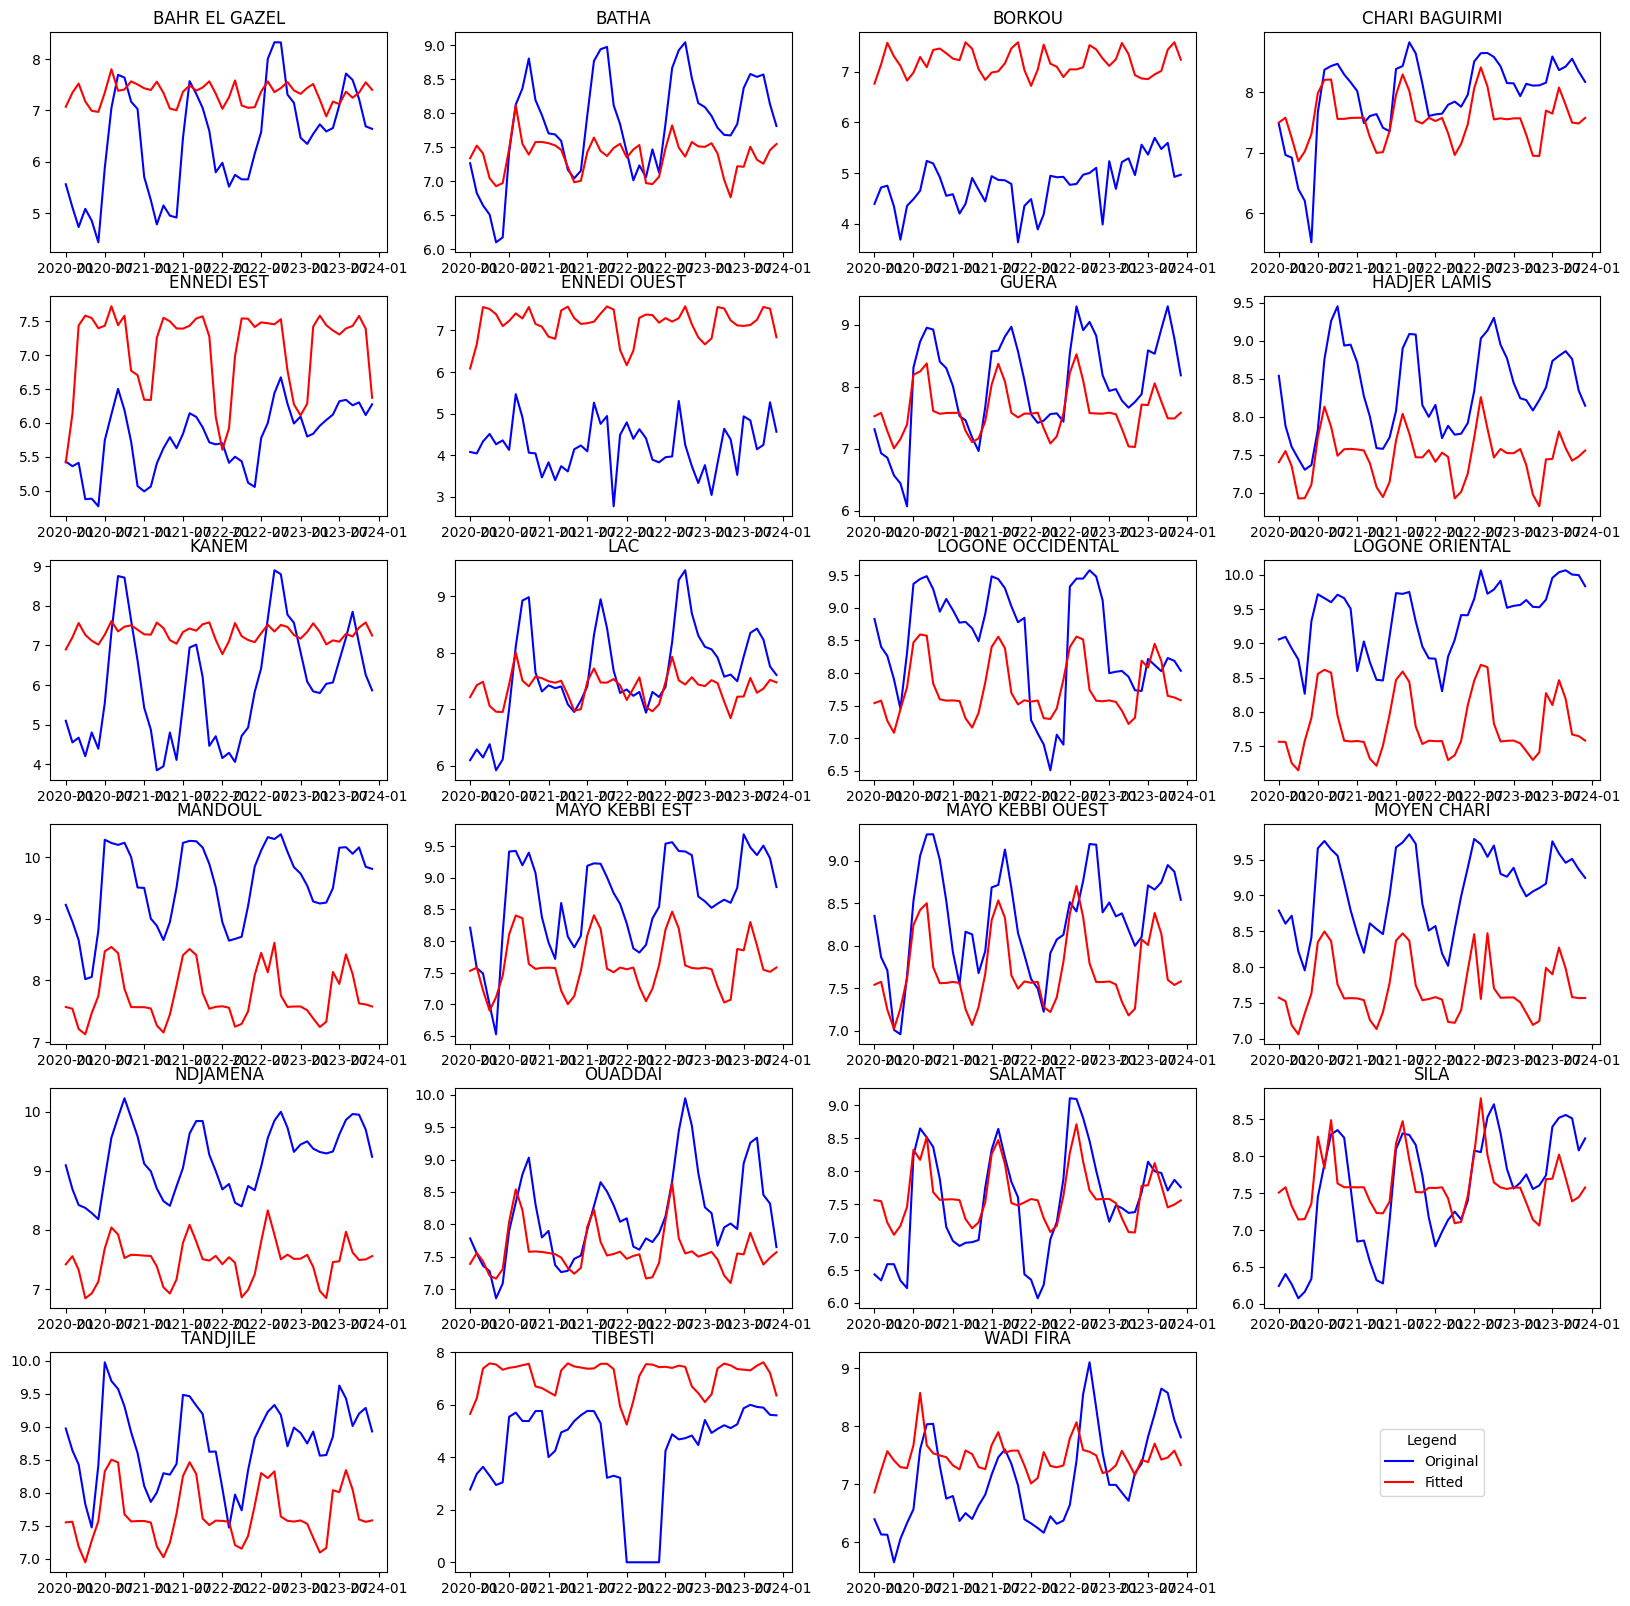

In [441]:
states = y.index.levels[0].tolist()

fig, axes = plt.subplots(6,4, figsize=(20,20))
xticks = range(47)
for i in range(23):
    idx = i // 4
    idy = i % 4
    sub_y = y.loc[states[i]]
    sub_pred = re_results.fitted_values['fitted_values'].loc[states[i]]
    axes[idx,idy].plot(sub_y, label='Original', color='blue')
    axes[idx,idy].plot(sub_pred, label='Fitted', color='red')
    # axes[idx,idy].fill_between(xticks, inf_, sup_, color='black', alpha=0.5)
    axes[idx,idy].set_title(states[i])

axes[5, 3].clear()
axes[5, 3].axis('off')
handles, labels = axes[0, 0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.5), bbox_transform=axes[5, 3].transAxes, title='Legend')

# plt.savefig('../../docs/predictions.png', bbox_inches='tight', pad_inches=0.1)

# ACF and PACF

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming df is your dataframe with 'time', 'entity', and 'cases' columns
entities = data['state'].unique()  # Get unique entities in the panel
n_entities = len(entities)  # Number of entities
ncols = 4  # Number of columns in the plot grid
nrows = (n_entities * 2 // ncols) + (n_entities * 2 % ncols > 0)   # Number of rows

# Create subplots
def plt_acfs(varname, entities, nrows, ncols, data):
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows * 2))  # Adjust figure size as needed
    axs = axs.flatten()  # Flatten the 2D array of axes to iterate easily

    for i, entity in enumerate(entities):
        entity_data = data[data['state'] == entity].sort_values(by='time')[varname]  # Filter and sort data by time
        
        # Plot ACF
        plot_acf(entity_data, lags=20, ax=axs[i * 2])  # ACF plot
        axs[i * 2].set_title(f'ACF for {entity}')
        
        # Plot PACF
        plot_pacf(entity_data, lags=20, ax=axs[i * 2 + 1])  # PACF plot
        axs[i * 2 + 1].set_title(f'PACF for {entity}')

    # Remove any unused subplots (if nrows * ncols > number of plots)
    for j in range(i * 2 + 2, nrows * ncols):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.savefig(f'../../docs/acf-pacf-{varname}.png', format='png', bbox_inches='tight', pad_inches=0)
    plt.show()

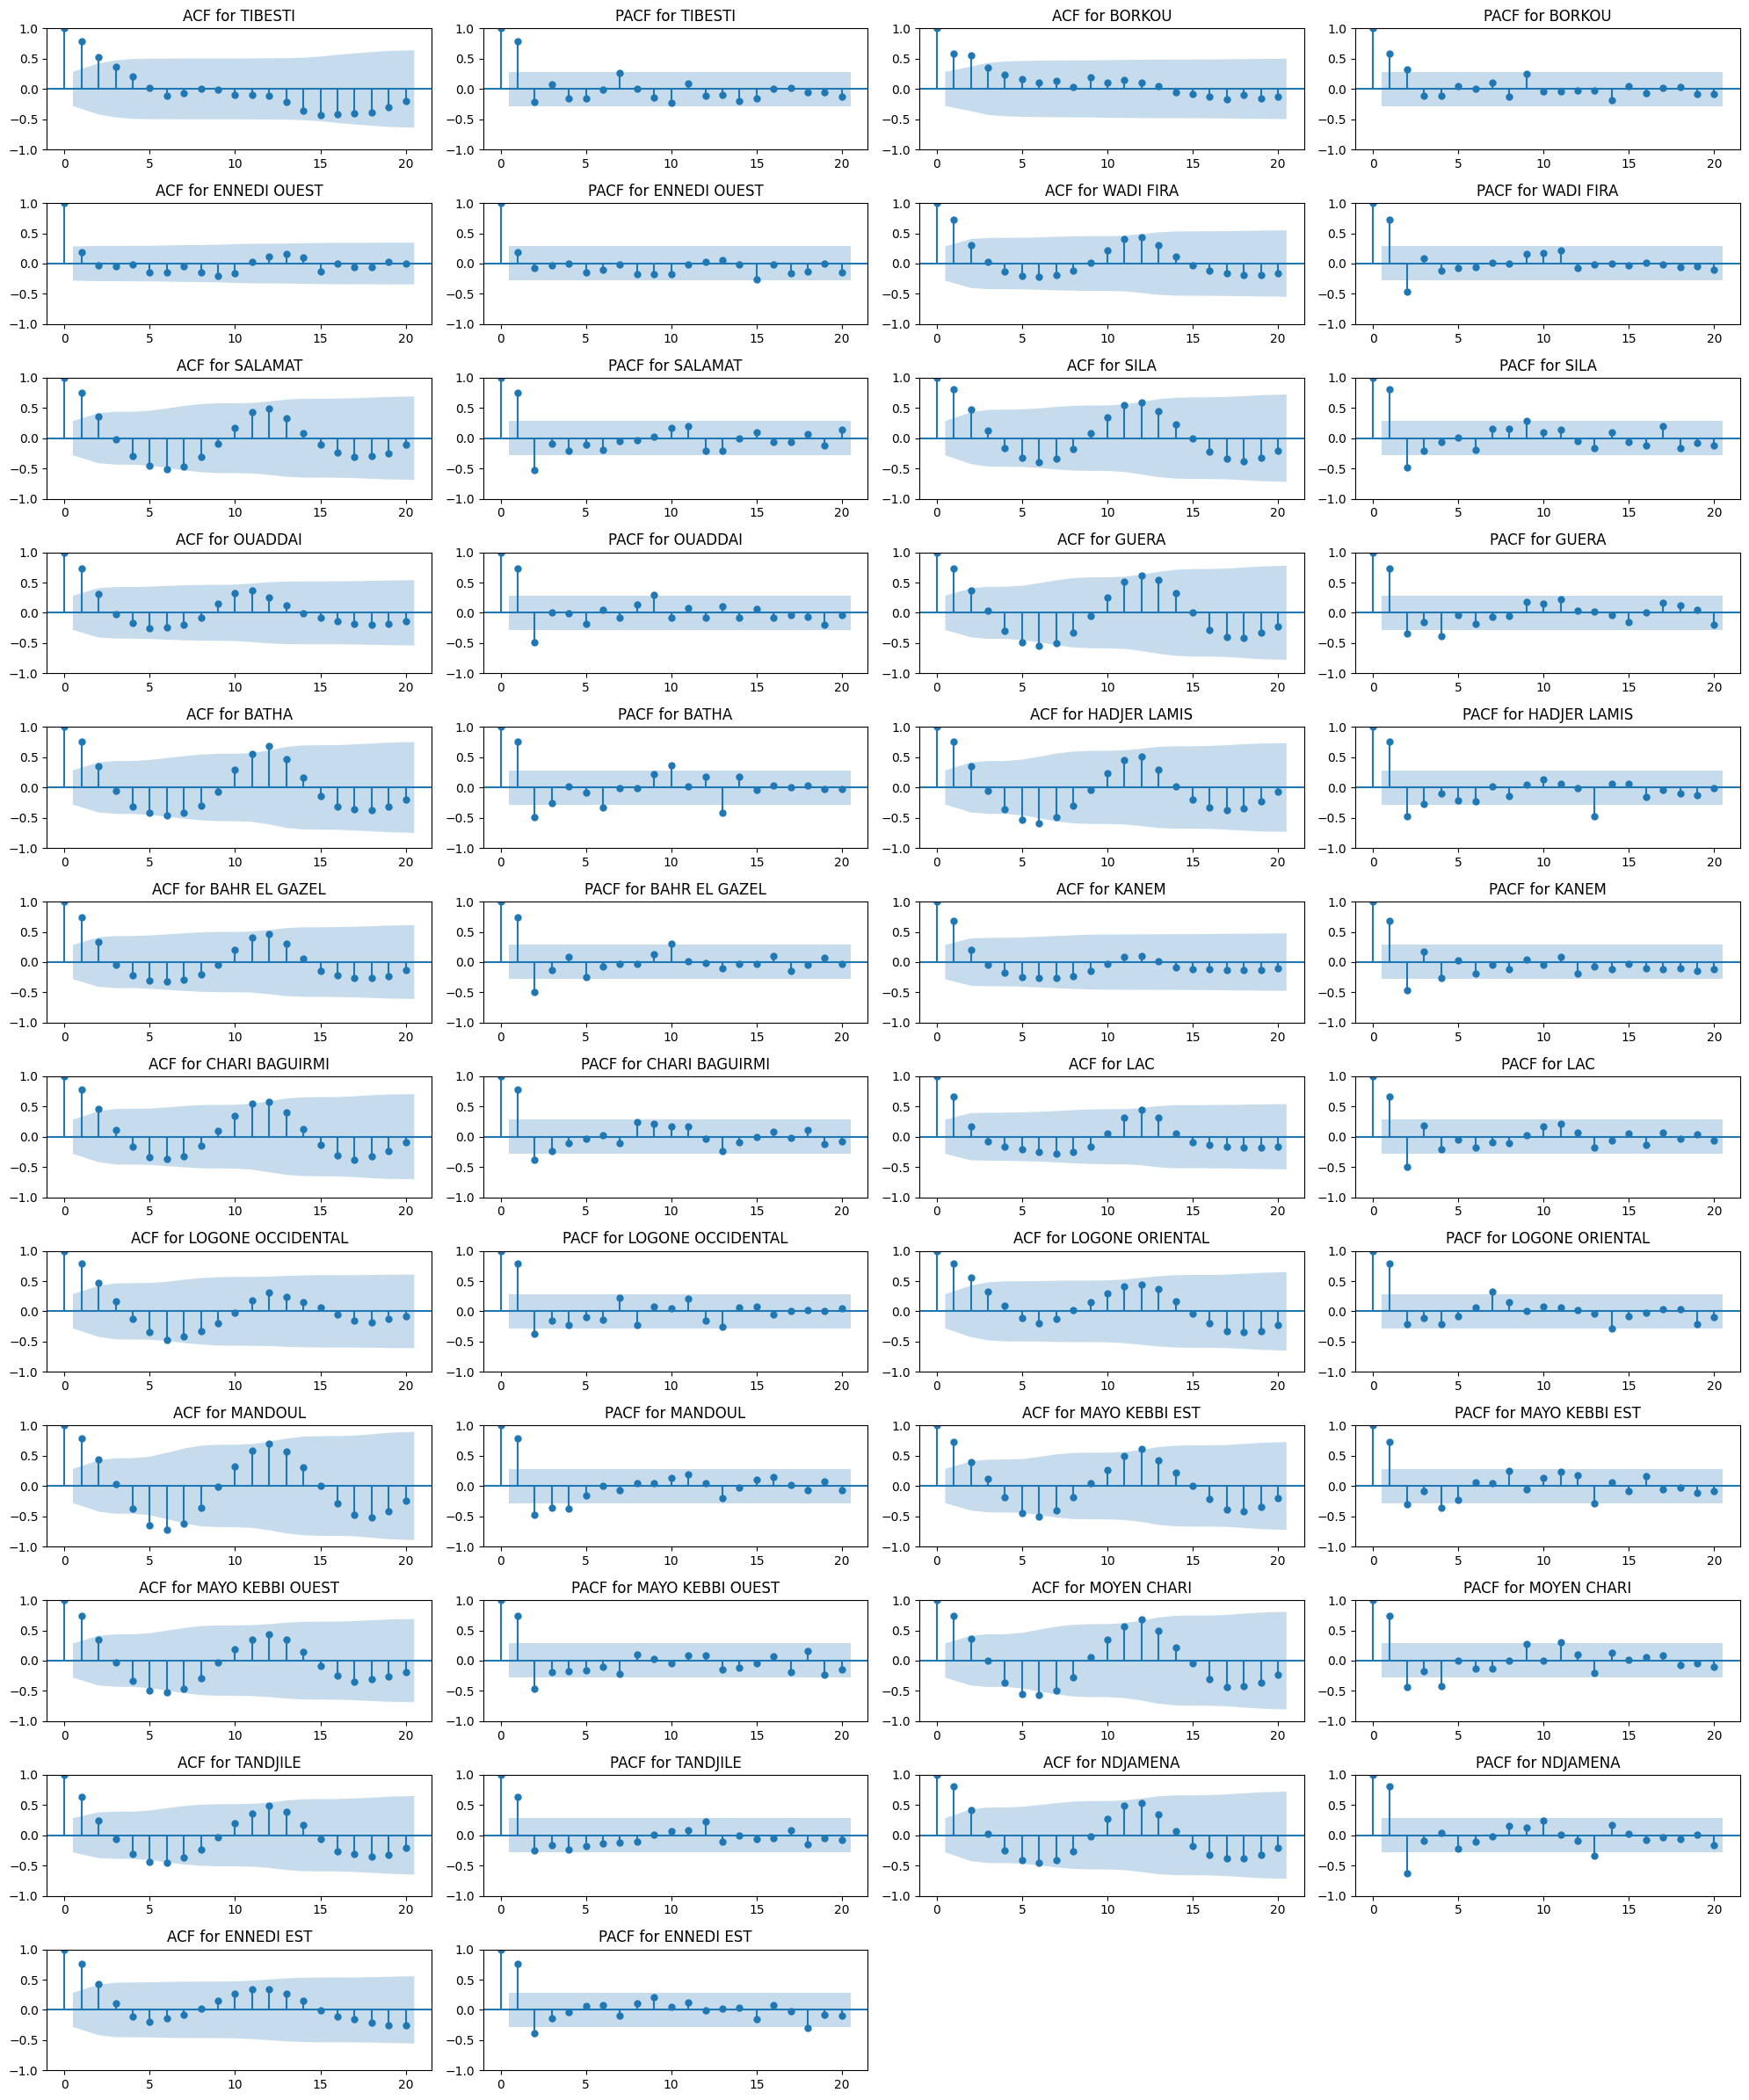

In [30]:
plt_acfs('cases', entities, nrows, ncols, data)

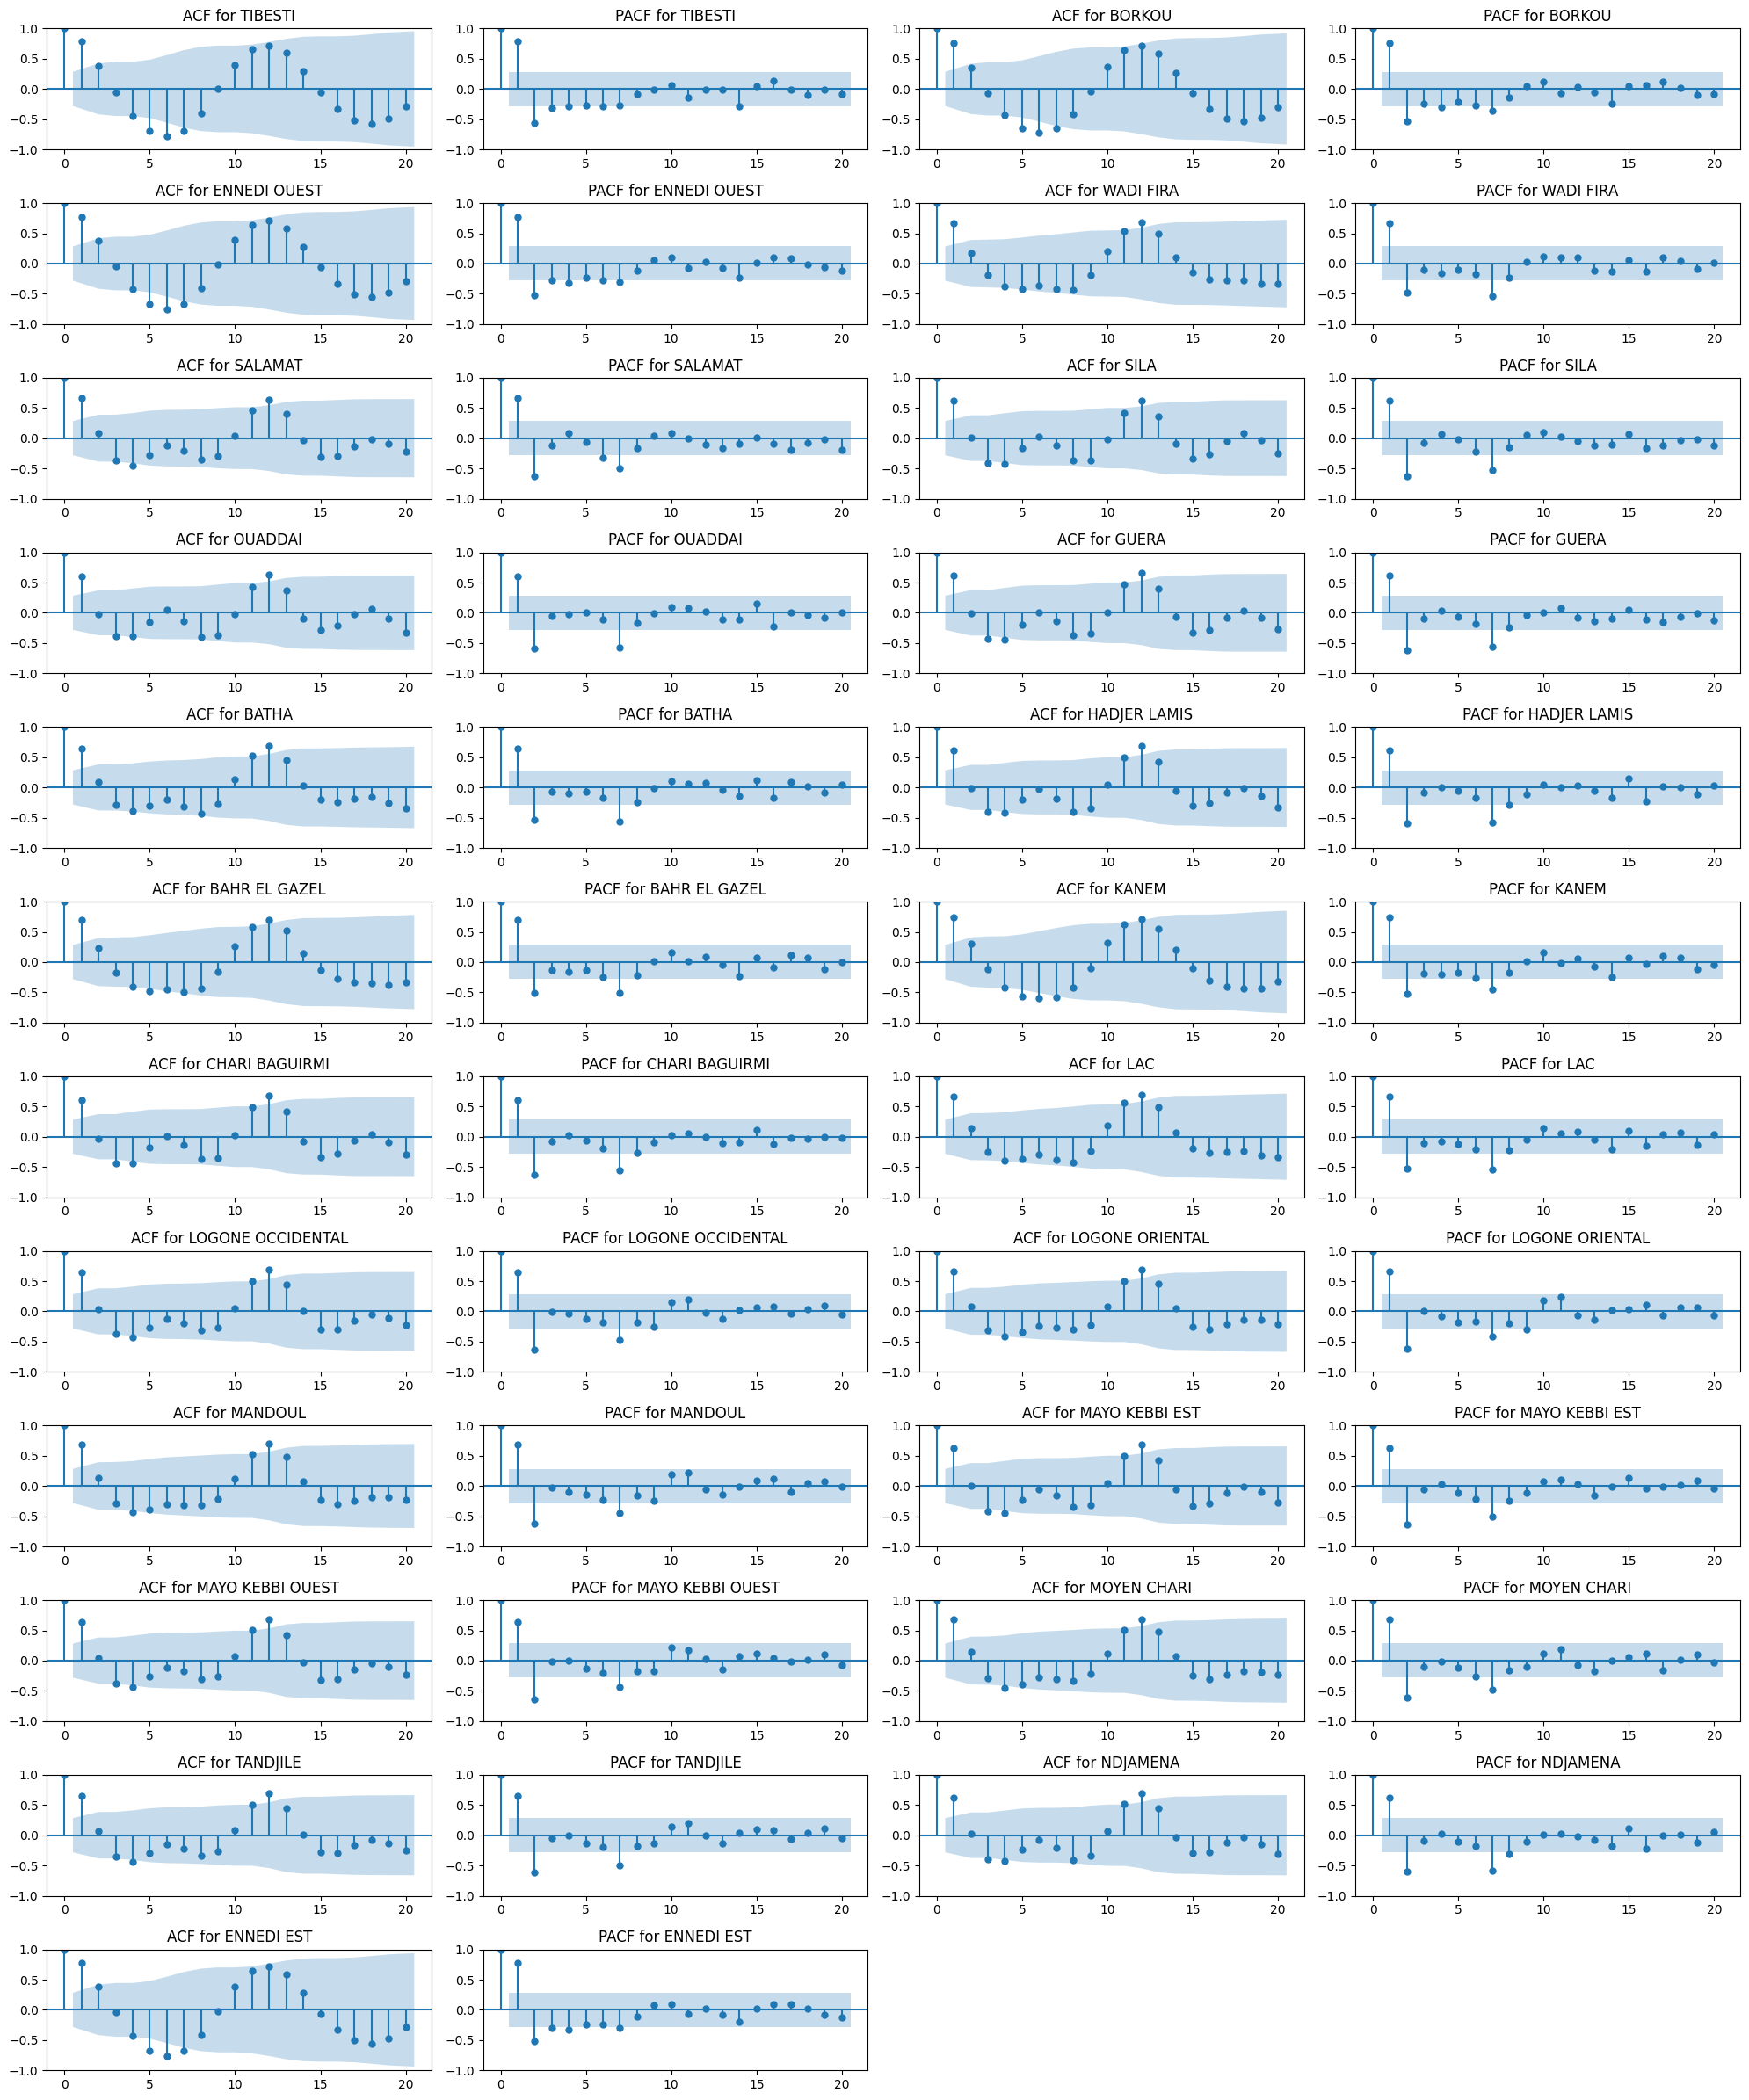

In [31]:
plt_acfs('t2m', entities, nrows, ncols, data)

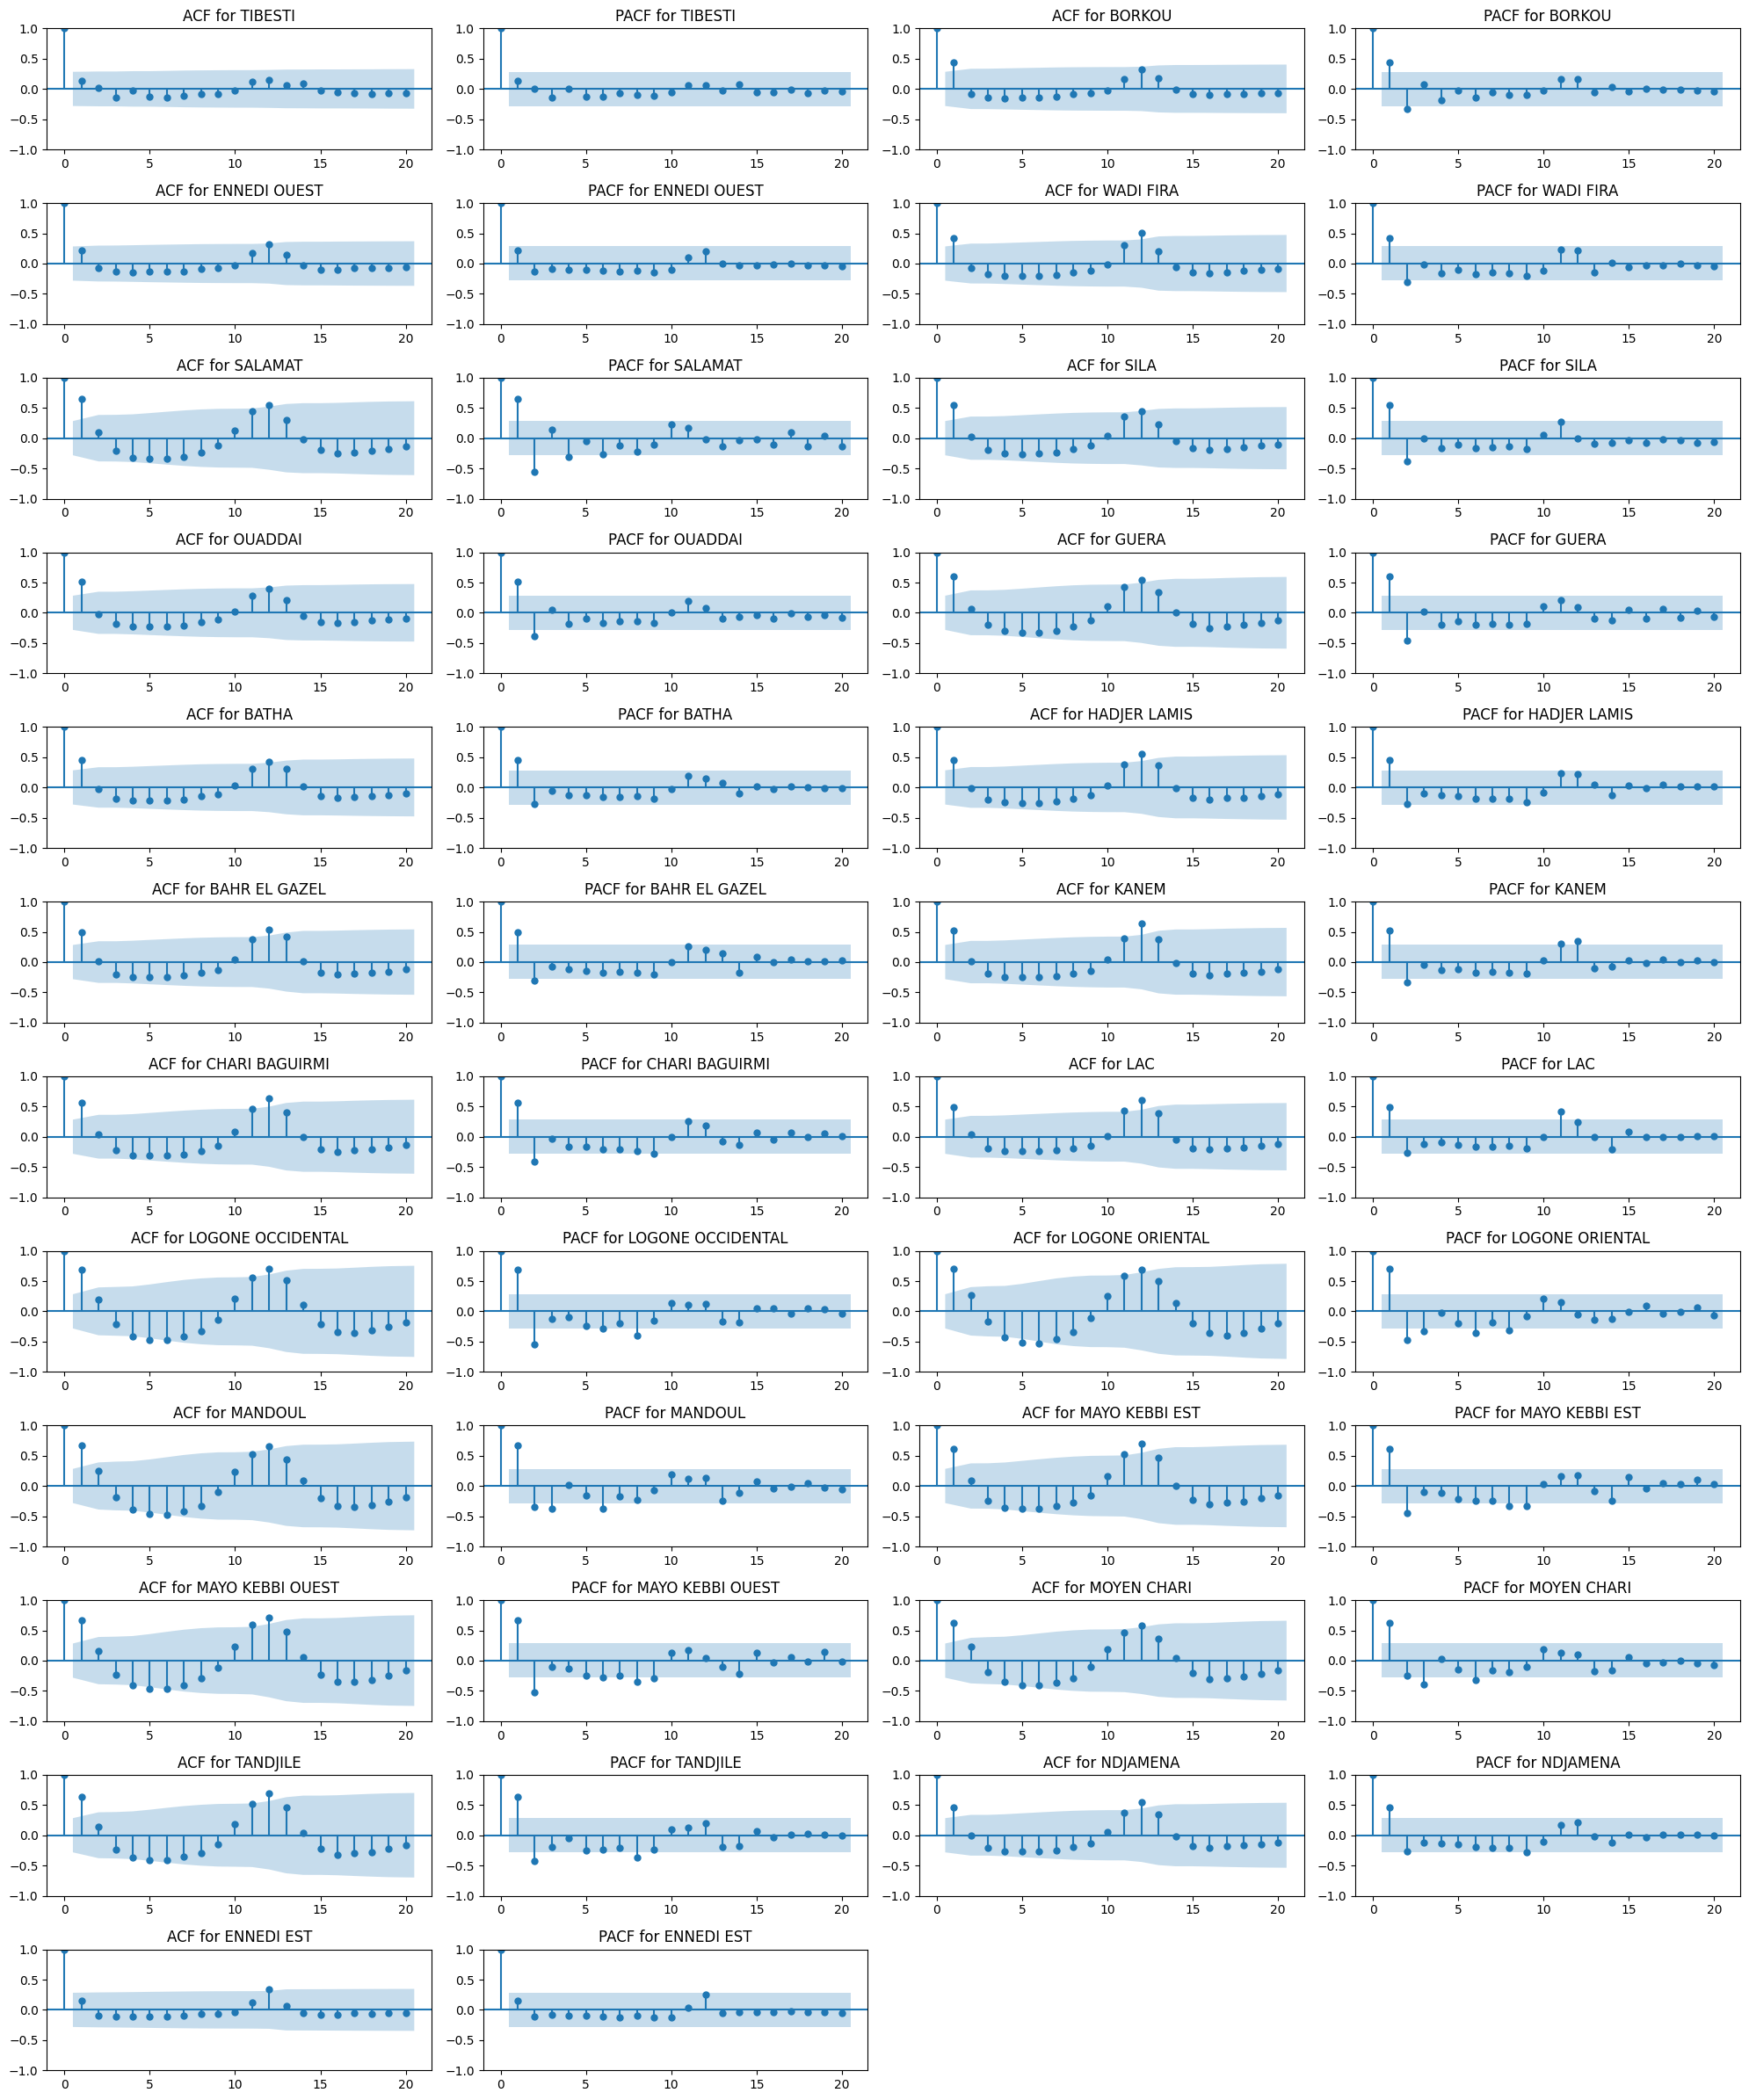

In [32]:
plt_acfs('tp', entities, nrows, ncols, data)

In [108]:
import pandas as pd
from  pydynpd import regression

command_str='cases L(1:2).cases t2m tp | gmm(t2m, 2:99) gmm(tp, 2:99)| nolevel collapse'
mydpd = regression.abond(command_str, data, ['state', 'time'])

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: state                            Number of obs = 1035     
 Time variable: time                              Min obs per group: 45    
 Number of instruments = 95                       Max obs per group: 45    
 Number of groups = 23                            Avg obs per group: 45.00 
+----------+--------------+---------------------+------------+-----------+-----+
|  cases   |    coef.     | Corrected Std. Err. |     z      |   P>|z|   |     |
+----------+--------------+---------------------+------------+-----------+-----+
| L1.cases |  0.1554223   |      0.0367909      | 4.2244721  | 0.0000240 | *** |
| L2.cases |  -0.0175567  |      0.0699419      | -0.2510188 | 0.8017995 |     |
|   t2m    | 855.5048868  |     350.6337752     | 2.4398816  | 0.0146921 |  *  |
|    tp    | 3058.8316950 |     1056.9598447    | 2.8939904  | 0.0038038 |  ** |
+----------+--------------+---------------------+------------+-----------

# Random Effects

In [20]:
from linearmodels.panel import RandomEffects

# Set the index for panel data
data.set_index(['state', 'time'], inplace=True)

# Fit a random effects model
model_re = RandomEffects.from_formula('cases ~ t2m + tp', data)
result_re = model_re.fit()

# Print the summary of the random effects model
print(result_re)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  cases   R-squared:                        0.1921
Estimator:              RandomEffects   R-squared (Between):              0.3958
No. Observations:                1104   R-squared (Within):               0.1756
Date:                Thu, Nov 21 2024   R-squared (Overall):              0.3454
Time:                        17:42:07   Log-likelihood                -1.051e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      130.98
Entities:                          23   P-value                           0.0000
Avg Obs:                       48.000   Distribution:                  F(2,1102)
Min Obs:                       48.000                                           
Max Obs:                       48.000   F-statistic (robust):             130.98
                            

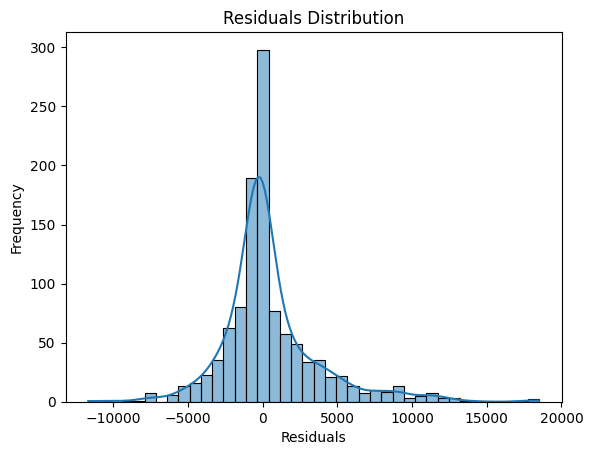

Mean: 4745.457427536232, Variance: 31871303.0208514


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
residuals = result_re.resids
sns.histplot(residuals, kde=True, bins=40)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Check for overdispersion
print(f"Mean: {data['cases'].mean()}, Variance: {data['cases'].var()}")

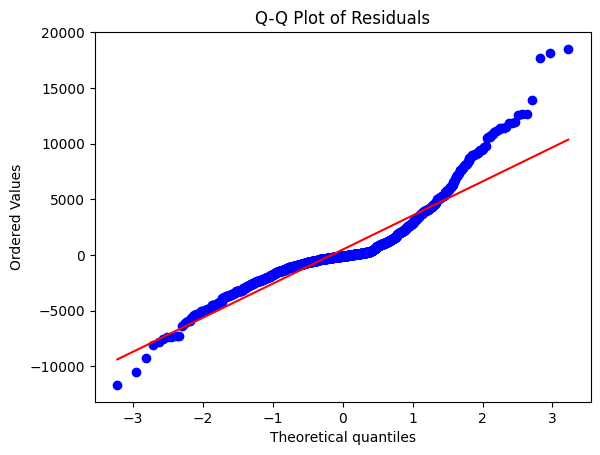

In [29]:
import scipy.stats as stats

# Q-Q plot for normality of residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

In [34]:
data[['t2m','tp']].to_numpy()

array([[1.32268626e+01, 6.18251819e-03],
       [1.79383110e+01, 1.74289364e-03],
       [1.48349634e+01, 1.22880390e-03],
       ...,
       [2.66994898e+01, 4.35007678e-04],
       [2.51725098e+01, 4.35007678e-04],
       [1.60303234e+01, 4.35007678e-04]])

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor
# X_train_const_numpy = np.array(X_train_const)  # Ensure it's a NumPy array
vif_data = pd.DataFrame()
vif_data["Variable"] = ['t2m', 'tp']
vif_data["VIF"] = [variance_inflation_factor(data[['t2m','tp']].to_numpy(), i) for i in range(2)]

print(vif_data)

  Variable       VIF
0      t2m  1.197866
1       tp  1.197866


In [38]:
from statsmodels.stats.stattools import durbin_watson

# Durbin-Watson statistic to check for autocorrelation
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")

# Interpretation
if dw_stat < 1.5:
    print("There may be positive autocorrelation.")
elif dw_stat > 2.5:
    print("There may be negative autocorrelation.")
else:
    print("No significant autocorrelation detected.")


Durbin-Watson statistic: 0.9230748906915162
There may be positive autocorrelation.


In [40]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Add a constant term to the independent variables
X_with_constant = sm.add_constant(data[['t2m', 'tp']])  # Adds a constant column for the intercept



# Breusch-Pagan test for heteroscedasticity
bp_test = het_breuschpagan(residuals, X_with_constant)

# The test returns: Lagrange multiplier statistic, p-value, f-value, f p-value
bp_lm_stat, bp_lm_pvalue, f_value, f_pvalue = bp_test
print("H0: Heteroscedasticity")
print(f"Breusch-Pagan Test: LM Statistic = {bp_lm_stat}, p-value = {bp_lm_pvalue}")


H0: Heteroscedasticity
Breusch-Pagan Test: LM Statistic = 23.661252618400674, p-value = 7.278204875482913e-06


# OLS estimation

In [18]:
import pandas as pd
from linearmodels.panel import PanelOLS

data['time'] = pd.to_datetime(data['time']) 
data['region'] = data['state']
df = data.set_index(['state', 'time'])


# Drop rows with missing lagged values (from the first time period)
df = df.dropna()

# Define dependent and independent variables
y = df['cases']
X = df[['t2m', 'tp', 'year', 'month', 'region']]

# Fit dynamic panel model (Fixed effects)
model_ols = PanelOLS(y, X, entity_effects=True, time_effects=False, drop_absorbed=True)
results_ols = model_ols.fit()

# Display results
print(results_ols.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  cases   R-squared:                        0.4908
Estimator:                   PanelOLS   R-squared (Between):             -0.7505
No. Observations:                1104   R-squared (Within):               0.4908
Date:                Wed, Sep 18 2024   R-squared (Overall):             -0.4669
Time:                        15:12:59   Log-likelihood                -1.021e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      64.157
Entities:                          23   P-value                           0.0000
Avg Obs:                       48.000   Distribution:                 F(16,1065)
Min Obs:                       48.000                                           
Max Obs:                       48.000   F-statistic (robust):             64.157
                            

/tmp/ipykernel_22826/1318744822.py:18: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

region.BATHA, region.BORKOU, region.CHARI BAGUIRMI, region.ENNEDI EST, region.ENNEDI OUEST, region.GUERA, region.HADJER LAMIS, region.KANEM, region.LAC, region.LOGONE OCCIDENTAL, region.LOGONE ORIENTAL, region.MANDOUL, region.MAYO KEBBI EST, region.MAYO KEBBI OUEST, region.MOYEN CHARI, region.NDJAMENA, region.OUADDAI, region.SALAMAT, region.SILA, region.TANDJILE, region.TIBESTI, region.WADI FIRA

  results_ols = model_ols.fit()


In [19]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Add a constant term to the independent variables
X_with_constant = sm.add_constant(X[['t2m', 'tp']])  # Adds a constant column for the intercept

# Get residuals from the fitted Random Effects model
residuals = results_ols.resids

# Breusch-Pagan test for heteroscedasticity
bp_test = het_breuschpagan(residuals, X_with_constant)

# The test returns: Lagrange multiplier statistic, p-value, f-value, f p-value
bp_lm_stat, bp_lm_pvalue, f_value, f_pvalue = bp_test
print(f"Breusch-Pagan Test: LM Statistic = {bp_lm_stat}, p-value = {bp_lm_pvalue}")


Breusch-Pagan Test: LM Statistic = 37.41512204769116, p-value = 7.506015855601077e-09


In [5]:
# Extract Fixed (Entity) Effects
fixed_effects = results_ols.estimated_effects
print("\nFixed Effects (Entity Effects):\n", fixed_effects)


Fixed Effects (Entity Effects):
                              estimated_effects
state            time                         
TIBESTI          2020-01-01        2432.866637
BORKOU           2020-01-01        3314.890753
ENNEDI OUEST     2020-01-01        2812.313736
WADI FIRA        2020-01-01        4413.816337
SALAMAT          2020-01-01        5144.639132
...                                        ...
MAYO KEBBI OUEST 2023-12-01        7211.623170
MOYEN CHARI      2023-12-01       12353.720417
TANDJILE         2023-12-01        9984.043558
NDJAMENA         2023-12-01       14409.187498
ENNEDI EST       2023-12-01        2628.786731

[1104 rows x 1 columns]


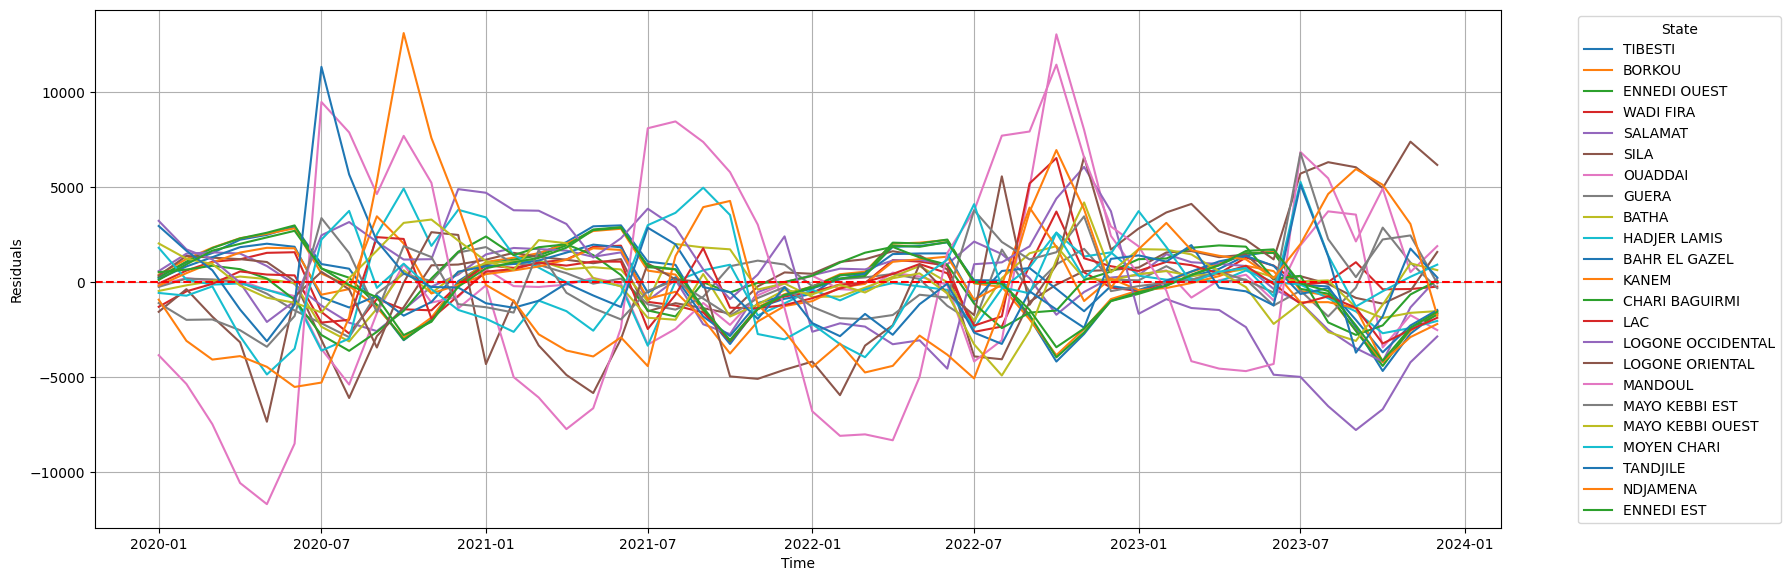

In [10]:
# Extract residuals
residuals = results_ols.resids

# Extract index levels: 'state' and 'time' (or whatever your index names are)
states = residuals.index.get_level_values(0)  # State level (first level)
time = residuals.index.get_level_values(1)  # Time level (second level)

# Convert residuals to DataFrame for easier plotting
residuals_df = pd.DataFrame({
    'residuals': residuals,
    'state': states,
    'time': time
})

# Plot residuals for each state using a line plot
plt.figure(figsize=(18, 6))
for state in residuals_df['state'].unique():
    state_residuals = residuals_df[residuals_df['state'] == state]
    plt.plot(state_residuals['time'], state_residuals['residuals'], label=state)

# Customize the plot
plt.axhline(0, color='r', linestyle='--')
# plt.title('Residuals Over Time by State')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
plt.tight_layout()

# Show the plot
plt.grid(True)

# Random Effects

In [31]:
import pandas as pd
from linearmodels.panel import RandomEffects

data['time'] = pd.to_datetime(data['time']) 
data['region'] = data['state']
df = data.set_index(['state', 'time'])


# Drop rows with missing lagged values (from the first time period)
df = df.dropna()

# Define dependent and independent variables
y = np.log(1+df['cases'])
X = df[['t2m', 'tp', 'year', 'month', 'region']]
X['t2m'] = np.log(X['t2m'])
X['tp'] = np.log(100*X['tp'])

model_random = RandomEffects(y, X) 
results_random = model_random.fit(cov_type='clustered', cluster_entity=True)

# Display results
print(results_random.summary)

/tmp/ipykernel_22826/2327543025.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['t2m'] = np.log(X['t2m'])
/tmp/ipykernel_22826/2327543025.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tp'] = np.log(100*X['tp'])


                        RandomEffects Estimation Summary                        
Dep. Variable:                  cases   R-squared:                        0.9940
Estimator:              RandomEffects   R-squared (Between):              1.0000
No. Observations:                1104   R-squared (Within):               0.4590
Date:                Wed, Sep 18 2024   R-squared (Overall):              0.9940
Time:                        15:23:08   Log-likelihood                   -1001.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4611.5
Entities:                          23   P-value                           0.0000
Avg Obs:                       48.000   Distribution:                 F(38,1066)
Min Obs:                       48.000                                           
Max Obs:                       48.000   F-statistic (robust):          4.177e+17
                            

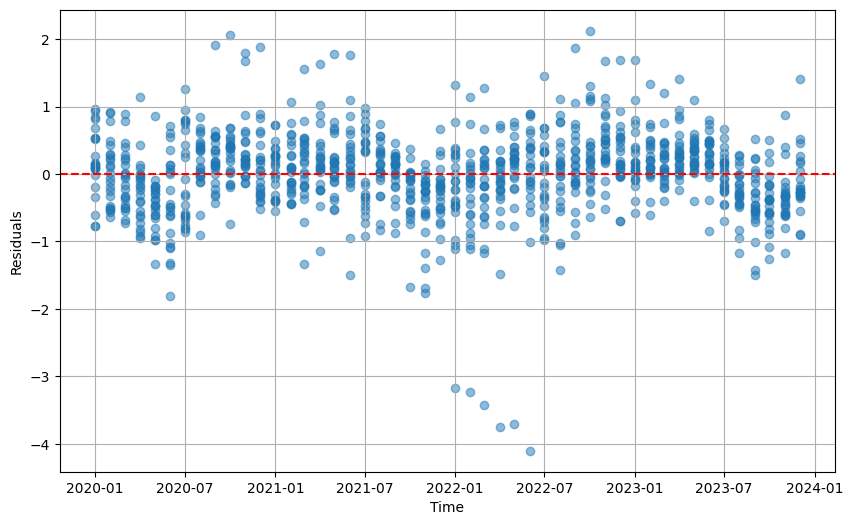

In [32]:
# Extract residuals
residuals = results_random.resids

# Create a residuals plot
plt.figure(figsize=(10,6))

# Option 1: Using Matplotlib
plt.scatter(residuals.index.get_level_values(1), residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

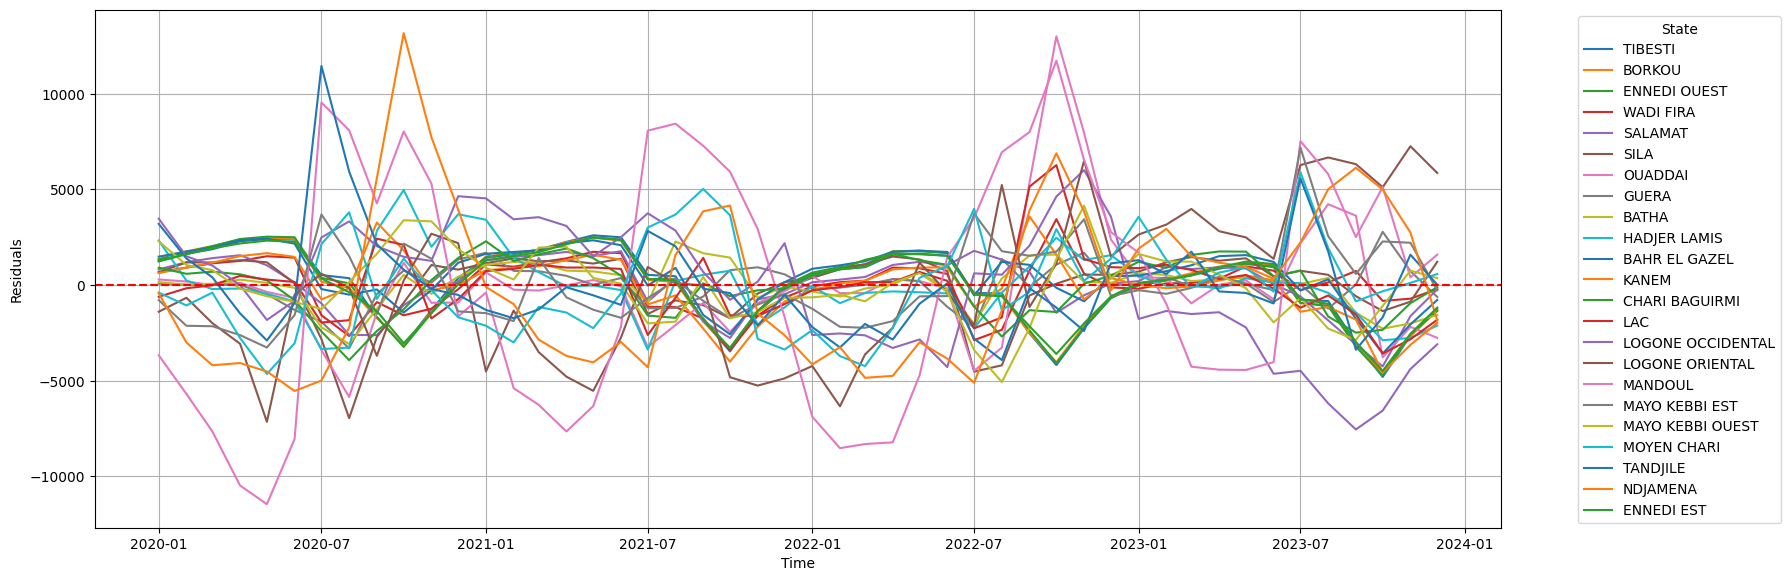

In [22]:
# Extract residuals
residuals = results_random.resids

# Extract index levels: 'state' and 'time' (or whatever your index names are)
states = residuals.index.get_level_values(0)  # State level (first level)
time = residuals.index.get_level_values(1)  # Time level (second level)

# Convert residuals to DataFrame for easier plotting
residuals_df = pd.DataFrame({
    'residuals': residuals,
    'state': states,
    'time': time
})

# Plot residuals for each state using a line plot
plt.figure(figsize=(18, 6))
for state in residuals_df['state'].unique():
    state_residuals = residuals_df[residuals_df['state'] == state]
    plt.plot(state_residuals['time'], state_residuals['residuals'], label=state)

# Customize the plot
plt.axhline(0, color='r', linestyle='--')
# plt.title('Residuals Over Time by State')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
plt.tight_layout()

# Show the plot
plt.grid(True)
plt.savefig('../../docs/residuals.png', format='png', bbox_inches='tight', pad_inches=0)
plt.show()

In [8]:
X[['t2m', 'tp']]

,,t2m,tp
state,time,,
TIBESTI,2020-01-01,13.226863,0.006183
BORKOU,2020-01-01,17.938311,0.001743
ENNEDI OUEST,2020-01-01,14.834963,0.001229
WADI FIRA,2020-01-01,18.471732,0.001052
SALAMAT,2020-01-01,25.261679,0.001052
...,...,...,...
MAYO KEBBI OUEST,2023-12-01,26.830964,0.000435
MOYEN CHARI,2023-12-01,27.814579,0.000619
TANDJILE,2023-12-01,26.699490,0.000435


## Model validation
To properly validate the random effects model for homoscedasticity and no autocorrelation assumptions.
* Breusch-Pagan Test checks for heteroscedasticity in residuals.
* Durbin-Watson Test checks for first-order autocorrelation.
* Breusch-Godfrey Test checks for higher-order autocorrelation.

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Add a constant term to the independent variables
X_with_constant = sm.add_constant(X[['t2m', 'tp']])  # Adds a constant column for the intercept

# Get residuals from the fitted Random Effects model
residuals = results_random.resids

# Breusch-Pagan test for heteroscedasticity
bp_test = het_breuschpagan(residuals, X_with_constant)

# The test returns: Lagrange multiplier statistic, p-value, f-value, f p-value
bp_lm_stat, bp_lm_pvalue, f_value, f_pvalue = bp_test
print("H0: Heteroscedasticity")
print(f"Breusch-Pagan Test: LM Statistic = {bp_lm_stat}, p-value = {bp_lm_pvalue}")


Breusch-Pagan Test: LM Statistic = 21.18865629092773, p-value = 2.5057731246298692e-05


In [7]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Get the residuals from your model (Random Effects model or any model)
residuals = results_random.resids
exog = X[['t2m', 'tp']]  # Explanatory variables (independent variables)

# Breusch-Pagan test for heteroscedasticity
bp_test = het_breuschpagan(residuals, exog)

# The test returns: Lagrange multiplier statistic, p-value, f-value, f p-value
bp_lm_stat, bp_lm_pvalue, f_value, f_pvalue = bp_test
print(f"Breusch-Pagan Test: LM Statistic = {bp_lm_stat}, p-value = {bp_lm_pvalue}")


ValueError: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.

In [9]:
from statsmodels.stats.stattools import durbin_watson

# Get residuals from your model
residuals = results_random.resids

# Perform Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic = {dw_stat}")


Durbin-Watson statistic = 1.5152948617090316


The value of the Durbin-Watson statistic ranges from 0 to 4:
* A value close to 2 indicates no autocorrelation.
* A value closer to 0 suggests positive autocorrelation.
* A value closer to 4 suggests negative autocorrelation.

In [11]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

# Breusch-Godfrey test for autocorrelation
bg_test = acorr_breusch_godfrey(results_random, nlags=2)  # Specify the number of lags
bg_lm_stat, bg_lm_pvalue, f_value, f_pvalue = bg_test
print(f"Breusch-Godfrey Test: LM Statistic = {bg_lm_stat}, p-value = {bg_lm_pvalue}")


AttributeError: 'RandomEffectsResults' object has no attribute 'resid'

# Test for individual random effects (Hausman)

In [100]:
from scipy import stats

# 3. Extract coefficients and covariance matrices
beta_fixed = results_ols.params
beta_random = results_random.params

cov_fixed = results_ols.cov
cov_random = results_random.cov

# 4. Compute the Hausman test statistic
diff = beta_fixed - beta_random
chi2_stat = np.dot(np.dot(diff.T, np.linalg.inv(cov_fixed - cov_random)), diff)
p_value = stats.chi2.sf(chi2_stat, df=len(diff))

# Display the results
print(f"Hausman test statistic: {chi2_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject null hypothesis: Fixed Effects model is preferred.")
else:
    print("Fail to reject null hypothesis: Random Effects model is preferred.")


Hausman test statistic: 62.51834025536211
P-value: 1.7023383371844174e-13
Reject null hypothesis: Fixed Effects model is preferred.


In [101]:
results_random.estimated_effects

,,estimated_effects
state,time,
TIBESTI,2020-02-01,0.0
BORKOU,2020-02-01,0.0
ENNEDI OUEST,2020-02-01,0.0
WADI FIRA,2020-02-01,0.0
SALAMAT,2020-02-01,0.0
...,...,...
MAYO KEBBI OUEST,2023-12-01,0.0
MOYEN CHARI,2023-12-01,0.0
TANDJILE,2023-12-01,0.0


In [63]:
results_random.df_resid

1078

In [90]:
from linearmodels.panel import compare
from linearmodels.panel import PanelOLS

# Compare the random effects and fixed effects models
comparison = compare({"Random Effects": results_random, "Fixed Effects": results_ols})
print(comparison)

                    Model Comparison                    
                           Random Effects  Fixed Effects
--------------------------------------------------------
Dep. Variable                       cases          cases
Estimator                   RandomEffects       PanelOLS
No. Observations                     1081           1081
Cov. Est.                      Unadjusted     Unadjusted
R-squared                          0.9233         0.6973
R-Squared (Within)                 0.6817         0.6973
R-Squared (Between)                0.9948         0.9779
R-Squared (Overall)                0.9233         0.9139
F-statistic                        4326.8         810.12
P-value (F-stat)                   0.0000         0.0000
=====================     ===============   ============
cases_lag                          0.8479         0.7257
                                 (74.053)       (41.504)
t2m                                6.2978         18.123
                               

# GMM estimation

In [36]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import GMM


In [37]:
gmm_model = GMM(y, X, weights=True)
gmm_res = gmm_model.fit()
print(gmm_res.summary)


TypeError: GMM.__init__() missing 1 required positional argument: 'instrument'